# Training public data

code written by following this github: https://github.com/ni79ls/har-keras-cnn

In [59]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import math

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, LSTM, Embedding, SimpleRNN, GRU
from keras.utils import np_utils
from tensorflow.keras import optimizers

import warnings
warnings.filterwarnings('ignore')

In [60]:
# data = pd.read_csv("Sisfall_dataset/processed_data.csv")

# data

data = pd.read_csv("data/combined_data.csv")

data

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity
0,-0.060,0.020,1.010,3.150,-0.530,1.560,ramana,Fall
1,-0.060,0.060,1.030,-14.000,-2.360,2.290,ramana,Fall
2,-0.060,-0.010,1.010,-25.850,-4.800,0.460,ramana,Fall
3,-0.060,-0.030,1.000,-7.660,-4.800,6.260,ramana,Fall
4,-0.040,-0.020,1.040,-0.880,-3.160,4.120,ramana,Fall
...,...,...,...,...,...,...,...,...
56635,0.000,0.000,1.000,-2.000,1.000,-7.000,zeon,Walking
56636,0.000,0.000,1.000,-13.000,-1.000,-6.000,zeon,Walking
56637,0.000,0.000,1.000,0.000,0.000,-5.000,zeon,Walking
56638,0.000,0.000,0.000,-15.000,8.000,13.000,zeon,Walking


In [61]:
# data = data[data['activity']!="D18"]
# data = data[data['activity']!="D19"]
data = data[data['activity']!="Jogging"]

In [62]:
# All data collected in 20Hz sample rate.

# Set display upto 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Labels are all the activity groups
# LABELS = list(data.groupby(["broad_mapped_activity"]).groups.keys())
LABELS = list(data.groupby(["activity"]).groups.keys())

no_of_features = 6

# The number of steps within one time segment (window size)
TIME_PERIODS = 60
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 15

LABELS

['Fall', 'Sitting action', 'Walking', 'climbing stairs', 'getting up']

In [68]:
# # split the data into training and test set
# Training_data = data[~data["user"].isin(['SA17', 'SA18', 'SA19', 'SA20', 'SA21'])]
# print(Training_data.shape)
# Test_data = data[data["user"].isin(['SA17', 'SA18', 'SA19', 'SA20', 'SA21'])]
# Test_data

# split the data into training and test set
Training_data = data[data["user"].isin(['ramana', 'wira'])]
zeon_data = data[data["user"].isin(['zeon'])]
Training_data = Training_data.append(zeon_data[~zeon_data["activity"].isin(["climbing stairs"])])
print(Training_data.shape)
Test_data = data[data["user"].isin(['wamika'])]
Test_data = Test_data.append(zeon_data[zeon_data["activity"].isin(["climbing stairs"])])
Test_data

(37200, 8)


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity
16980,0.130,-0.020,1.050,-4.590,6.800,-0.640,wamika,Fall
16981,0.120,-0.010,1.060,-0.140,9.730,-2.590,wamika,Fall
16982,0.110,-0.000,1.060,0.230,9.490,-2.280,wamika,Fall
16983,0.100,-0.010,1.060,-1.840,9.610,-1.370,wamika,Fall
16984,0.120,-0.000,1.070,-1.050,11.380,-1.000,wamika,Fall
...,...,...,...,...,...,...,...,...
53215,0.000,0.000,0.000,0.000,-6.000,-13.000,zeon,climbing stairs
53216,0.000,0.000,0.000,-13.000,-1.000,-3.000,zeon,climbing stairs
53217,0.000,0.000,0.000,14.000,9.000,11.000,zeon,climbing stairs
53218,0.000,0.000,0.000,7.000,2.000,21.000,zeon,climbing stairs


In [69]:
# Encode labels
le = preprocessing.LabelEncoder()
Training_data['encoded_label'] = le.fit_transform(Training_data['activity'].values.ravel())
print(list(le.classes_))

['Fall', 'Sitting action', 'Walking', 'climbing stairs', 'getting up']


In [70]:
def normalize_features(data, mu, sigma):
    print("mean: ", mu)
    print("standard deviation: ", sigma)
    return (data - mu)/sigma
#     maxim = np.max(data, axis=0)
#     minim = np.min(data, axis=0)
#     return (data - minim)/(maxim - minim)

In [71]:
mu = []
sigma = []
for i in range(0,6):
    print(Training_data.columns[i])
    mu.append(np.mean(Training_data.iloc[:, i], axis=0))
    sigma.append(np.std(Training_data.iloc[:, i], axis=0))
    Training_data.iloc[:, i] = normalize_features(Training_data.iloc[:, i], mu[i], sigma[i])
    
Training_data

accel_x
mean:  0.016859139784946162
standard deviation:  0.3169782064815828
accel_y
mean:  -0.036989516129032354
standard deviation:  0.298379167917324
accel_z
mean:  0.3306317204301088
standard deviation:  0.5189035834200442
gyro_x
mean:  -0.716561021505379
standard deviation:  55.572584842376756
gyro_y
mean:  -0.41315268817204404
standard deviation:  31.52775141330042
gyro_z
mean:  0.056315860215054955
standard deviation:  32.75767648225105


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity,encoded_label
0,-0.242,0.191,1.309,0.070,-0.004,0.046,ramana,Fall,0
1,-0.242,0.325,1.348,-0.239,-0.062,0.068,ramana,Fall,0
2,-0.242,0.090,1.309,-0.452,-0.139,0.012,ramana,Fall,0
3,-0.242,0.023,1.290,-0.125,-0.139,0.189,ramana,Fall,0
4,-0.179,0.057,1.367,-0.003,-0.087,0.124,ramana,Fall,0
...,...,...,...,...,...,...,...,...,...
56635,-0.053,0.124,1.290,-0.023,0.045,-0.215,zeon,Walking,2
56636,-0.053,0.124,1.290,-0.221,-0.019,-0.185,zeon,Walking,2
56637,-0.053,0.124,1.290,0.013,0.013,-0.154,zeon,Walking,2
56638,-0.053,0.124,-0.637,-0.257,0.267,0.395,zeon,Walking,2


In [72]:
def create_segments(data):

    segments = []
    labels = []
    for i in range(0, len(data) - TIME_PERIODS, STEP_DISTANCE):
        accel_xs = data['accel_x'].values[i: i + TIME_PERIODS]
        accel_ys = data['accel_y'].values[i: i + TIME_PERIODS]
        accel_zs = data['accel_z'].values[i: i + TIME_PERIODS]
        gyro_xs = data['gyro_x'].values[i: i + TIME_PERIODS]
        gyro_ys = data['gyro_y'].values[i: i + TIME_PERIODS]
        gyro_zs = data['gyro_z'].values[i: i + TIME_PERIODS]
#         mag_xs = data['mag_x'].values[i: i + TIME_PERIODS]
#         mag_ys = data['mag_y'].values[i: i + TIME_PERIODS]
#         mag_zs = data['mag_z'].values[i: i + TIME_PERIODS]
        
#         #Features
#         #mean
#         accel_x_mean = np.full(TIME_PERIODS, accel_xs.mean())
#     #     y_mean = np.full(TIME_PERIODS, ys.mean())
#         accel_z_mean = np.full(TIME_PERIODS, accel_zs.mean())
#         gyro_x_mean = np.full(TIME_PERIODS, gyro_xs.mean())
#     #     pitch_mean = np.full(TIME_PERIODS, pitchs.mean())
#         gyro_z_mean = np.full(TIME_PERIODS, gyro_zs.mean())
#         #standard deviation
#         accel_x_std = np.full(TIME_PERIODS, accel_xs.std())
#         accel_y_std = np.full(TIME_PERIODS, accel_ys.std())
#         accel_z_std = np.full(TIME_PERIODS, accel_zs.std())
#         gyro_x_std = np.full(TIME_PERIODS, gyro_xs.std())
#         gyro_y_std = np.full(TIME_PERIODS, gyro_ys.std())
#         gyro_z_std = np.full(TIME_PERIODS, gyro_zs.std())
#         #min
#         accel_x_min = np.full(TIME_PERIODS, accel_xs.min())
#         accel_y_min = np.full(TIME_PERIODS, accel_ys.min())
#         accel_z_min = np.full(TIME_PERIODS, accel_zs.min())
#         gyro_x_min = np.full(TIME_PERIODS, gyro_xs.min())
#     #     pitch_min = np.full(TIME_PERIODS, pitchs.min())
#     #     yaw_min = np.full(TIME_PERIODS, yaws.min())
    
#         #energy, here ** represents exponentiation
#         accel_x_eng = np.full(TIME_PERIODS, np.sum(accel_xs**2)/TIME_PERIODS) 
#         accel_y_eng = np.full(TIME_PERIODS, np.sum(accel_ys**2)/TIME_PERIODS)
#         accel_z_eng = np.full(TIME_PERIODS, np.sum(accel_zs**2)/TIME_PERIODS)
#         #median absolute deviation (MAD)
#         accel_x_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_xs))
#     #     y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(ys))
#         accel_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_zs))
#     #     roll_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(rolls))
#         gyro_y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_ys))
#         gyro_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_zs))
#         # signal magnitude area
#         accel_sma = np.full(TIME_PERIODS, (np.sum(np.abs(accel_xs)) + np.sum(np.abs(accel_ys)) + np.sum(np.abs(accel_zs))) / TIME_PERIODS)
#         gyro_sma = np.full(TIME_PERIODS, (np.sum(np.abs(gyro_xs)) + np.sum(np.abs(gyro_ys)) + np.sum(np.abs(gyro_zs))) / TIME_PERIODS)
# #         # get frequency domain signal
# #         x_freq = np.abs(np.fft.fft(xs))[1:51]
# #         y_freq = np.abs(np.fft.fft(ys))[1:51]
# #         z_freq = np.abs(np.fft.fft(zs))[1:51]
# #         roll_freq = np.abs(np.fft.fft(rolls))[1:51]
# #         pitch_freq = np.abs(np.fft.fft(pitchs))[1:51]
# #         yaw_freq = np.abs(np.fft.fft(yaws))[1:51]
# #         # freq mean
# #         x_freq_mean = np.full(TIME_PERIODS, x_freq.mean())
# #         y_freq_mean = np.full(TIME_PERIODS, y_freq.mean())
# #         z_freq_mean = np.full(TIME_PERIODS, z_freq.mean())
# #         roll_freq_mean = np.full(TIME_PERIODS, roll_freq.mean())
# #         pitch_freq_mean = np.full(TIME_PERIODS, pitch_freq.mean())
# #         yaw_freq_mean = np.full(TIME_PERIODS, yaw_freq.mean())
# #         #freq standard deviation
# #         x_freq_std = np.full(TIME_PERIODS, x_freq.std())
# #         y_freq_std = np.full(TIME_PERIODS, y_freq.std())
# #         z_freq_std = np.full(TIME_PERIODS, z_freq.std())
# #         roll_freq_std = np.full(TIME_PERIODS, roll_freq.std())
# #         pitch_freq_std = np.full(TIME_PERIODS, pitch_freq.std())
# #         yaw_freq_std = np.full(TIME_PERIODS, yaw_freq.std())

        # Retrieve the most often used label in this segment
        label = stats.mode(data['encoded_label'][i: i + TIME_PERIODS])[0][0]
        
#         segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs, accel_x_mean,\
#                          accel_z_mean, gyro_x_mean, gyro_z_mean, accel_x_std, accel_y_std, accel_z_std, gyro_x_std,  gyro_y_std, \
#                          gyro_z_std, accel_x_min, accel_y_min, accel_z_min, gyro_x_min, accel_x_eng, accel_y_eng, accel_z_eng, \
#                          accel_x_mad, accel_z_mad, gyro_y_mad, gyro_z_mad, accel_sma, gyro_sma])
        segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs])
        labels.append(label)

    # Bring the segments into a better shape
    x_data = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_PERIODS, no_of_features)
    y_data = np.asarray(labels)
    return x_data, y_data


In [73]:
x_train, y_train = create_segments(Training_data)
np.set_printoptions(threshold=np.inf)
print("x shape: ",x_train.shape)
print("y shape: ",y_train.shape)

x shape:  (2476, 60, 6)
y shape:  (2476,)


In [74]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS*no_of_features)
x_train.shape

(2476, 360)

In [75]:
# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, len(LABELS))
print('New y_train shape: ', y_train.shape)

New y_train shape:  (2476, 5)


### 1D-CNN Model

In [76]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS,no_of_features), input_shape=(TIME_PERIODS*no_of_features,)))
model_m.add(Conv1D(100, 3, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(120, 3, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(80, 3, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.3))
model_m.add(Dense(len(LABELS), activation='softmax'))
print(model_m.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 60, 6)             0         
                                                                 
 conv1d_9 (Conv1D)           (None, 58, 100)           1900      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 19, 100)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 17, 120)           36120     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 5, 120)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 3, 80)            

In [77]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_m.compile(loss='categorical_crossentropy',
                optimizer=opt, metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
13/13 [==============================] - 1s 39ms/step - loss: 1.5494 - accuracy: 0.2108
Epoch 2/50
13/13 [==============================] - 0s 13ms/step - loss: 1.2895 - accuracy: 0.4628
Epoch 3/50
13/13 [==============================] - 0s 13ms/step - loss: 1.1186 - accuracy: 0.5061
Epoch 4/50
13/13 [==============================] - 0s 13ms/step - loss: 0.9560 - accuracy: 0.6026
Epoch 5/50
13/13 [==============================] - 0s 13ms/step - loss: 0.7946 - accuracy: 0.6882
Epoch 6/50
13/13 [==============================] - 0s 13ms/step - loss: 0.6782 - accuracy: 0.7266
Epoch 7/50
13/13 [==============================] - 0s 13ms/step - loss: 0.5745 - accuracy: 0.7763
Epoch 8/50
13/13 [==============================] - 0s 13ms/step - loss: 0.5240 - accuracy: 0.7924
Epoch 9/50
13/13 [==============================] - 0s 13ms/step - loss: 0.4787 - accuracy: 0.8142
Epoch 10/50
13/13 [==============================] - 0s 14ms/step - loss: 0.4414 - accuracy: 0.8340
Epoch 11/

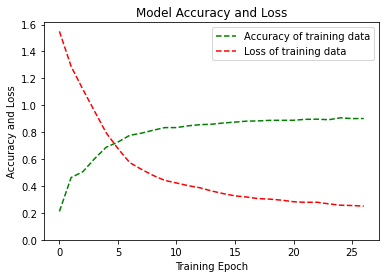

In [78]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [79]:
# Set input_shape / reshape for Keras
# Encode labels
Test_data['encoded_label'] = le.transform(Test_data['activity'].values.ravel())
print(list(le.classes_))

for i in range(0,6):
    print(data.columns[i])
    Test_data.iloc[:, i] = normalize_features(Test_data.iloc[:, i], mu[i], sigma[i])
    
x_test, y_test = create_segments(Test_data)
print("x shape: ",x_test.shape)
print("y shape: ",y_test.shape)

x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS*no_of_features)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, len(LABELS))
y_test.shape

['Fall', 'Sitting action', 'Walking', 'climbing stairs', 'getting up']
accel_x
mean:  0.016859139784946162
standard deviation:  0.3169782064815828
accel_y
mean:  -0.036989516129032354
standard deviation:  0.298379167917324
accel_z
mean:  0.3306317204301088
standard deviation:  0.5189035834200442
gyro_x
mean:  -0.716561021505379
standard deviation:  55.572584842376756
gyro_y
mean:  -0.41315268817204404
standard deviation:  31.52775141330042
gyro_z
mean:  0.056315860215054955
standard deviation:  32.75767648225105
x shape:  (984, 60, 6)
y shape:  (984,)


(984, 5)

In [80]:
score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

31/31 [==============================] - 0s 9ms/step - loss: 0.3403 - accuracy: 0.9309

Accuracy on test data: 0.93

Loss on test data: 0.34


In [56]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

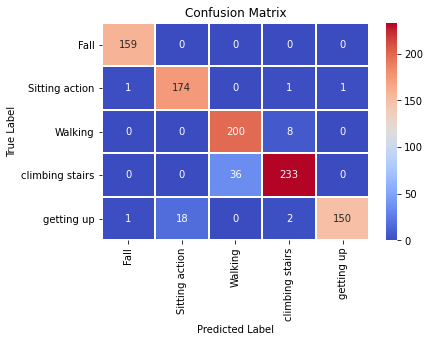


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       159
           1       0.91      0.98      0.94       177
           2       0.85      0.96      0.90       208
           3       0.95      0.87      0.91       269
           4       0.99      0.88      0.93       171

    accuracy                           0.93       984
   macro avg       0.94      0.94      0.94       984
weighted avg       0.94      0.93      0.93       984



In [81]:
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [82]:
model_m.save('best_model_cnn.h5')

### LSTM Model

In [83]:
model_lstm = Sequential()
model_lstm.add(LSTM(200, input_shape=(TIME_PERIODS,no_of_features)))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dense(len(LABELS), activation='softmax'))
print(model_lstm.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               165600    
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 5)                 505       
                                                                 
Total params: 186,205
Trainable params: 186,205
Non-trainable params: 0
_________________________________________________________________
None


In [84]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS, no_of_features)
x_train.shape

(2476, 60, 6)

In [85]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

opt = optimizers.Adam(learning_rate=0.001)

model_lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_lstm.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
13/13 [==============================] - 3s 42ms/step - loss: 0.6350 - accuracy: 0.2964
Epoch 2/50
13/13 [==============================] - 1s 40ms/step - loss: 0.4668 - accuracy: 0.3582
Epoch 3/50
13/13 [==============================] - 1s 40ms/step - loss: 0.3605 - accuracy: 0.5198
Epoch 4/50
13/13 [==============================] - 1s 40ms/step - loss: 0.2813 - accuracy: 0.6418
Epoch 5/50
13/13 [==============================] - 1s 40ms/step - loss: 0.2381 - accuracy: 0.6971
Epoch 6/50
13/13 [==============================] - 1s 40ms/step - loss: 0.2120 - accuracy: 0.7472
Epoch 7/50
13/13 [==============================] - 1s 40ms/step - loss: 0.1858 - accuracy: 0.7758
Epoch 8/50
13/13 [==============================] - 1s 41ms/step - loss: 0.1797 - accuracy: 0.7863
Epoch 9/50
13/13 [==============================] - 1s 41ms/step - loss: 0.1706 - accuracy: 0.7920
Epoch 10/50
13/13 [==============================] - 1s 40ms/step - loss: 0.1577 - accuracy: 0.8195
Epoch 11/

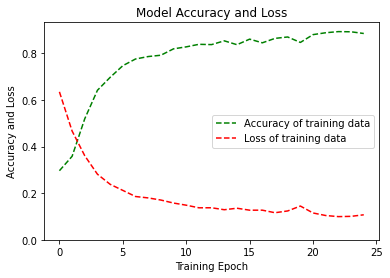

In [86]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [87]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS, no_of_features)
x_test.shape

(984, 60, 6)

In [88]:
score = model_lstm.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

31/31 [==============================] - 1s 11ms/step - loss: 0.2488 - accuracy: 0.7663

Accuracy on test data: 0.77

Loss on test data: 0.25


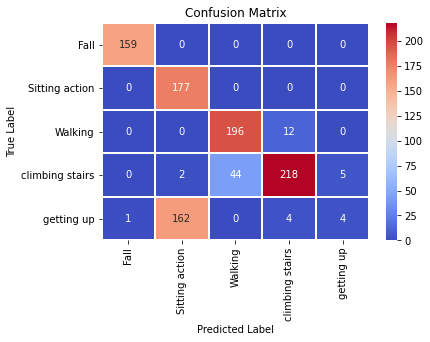


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       159
           1       0.52      1.00      0.68       177
           2       0.82      0.94      0.87       208
           3       0.93      0.81      0.87       269
           4       0.44      0.02      0.04       171

    accuracy                           0.77       984
   macro avg       0.74      0.76      0.69       984
weighted avg       0.76      0.77      0.71       984



In [89]:
y_pred_test = model_lstm.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [91]:
model_lstm.save('best_model_lstm.h5')

### 1D CNN + LSTM Model

In [90]:
model_lsnet = Sequential()
model_lsnet.add(Conv1D(100, 3, activation='relu', input_shape=(TIME_PERIODS,no_of_features)))
model_lsnet.add(MaxPooling1D(3))
model_lsnet.add(LSTM(200, return_sequences=True))
model_lsnet.add(Conv1D(100, 3, activation='relu'))
model_lsnet.add(MaxPooling1D(3))
model_lsnet.add(Conv1D(80, 3, activation='relu'))
model_lsnet.add(GlobalAveragePooling1D())
model_lsnet.add(Dropout(0.4))
model_lsnet.add(Dense(100, activation='relu'))
model_lsnet.add(Dense(len(LABELS), activation='softmax'))
print(model_lsnet.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 58, 100)           1900      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 19, 100)          0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 19, 200)           240800    
                                                                 
 conv1d_13 (Conv1D)          (None, 17, 100)           60100     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 5, 100)           0         
 1D)                                                             
                                                                 
 conv1d_14 (Conv1D)          (None, 3, 80)            

In [92]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS, no_of_features)
x_train.shape

(2476, 60, 6)

In [93]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

# opt = optimizers.RMSprop(learning_rate=0.001, momentum=0.9)

model_lsnet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_lsnet.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
13/13 [==============================] - 2s 44ms/step - loss: 0.5557 - accuracy: 0.2609
Epoch 2/50
13/13 [==============================] - 0s 30ms/step - loss: 0.4100 - accuracy: 0.4447
Epoch 3/50
13/13 [==============================] - 0s 30ms/step - loss: 0.3537 - accuracy: 0.5097
Epoch 4/50
13/13 [==============================] - 0s 30ms/step - loss: 0.3049 - accuracy: 0.5836
Epoch 5/50
13/13 [==============================] - 0s 30ms/step - loss: 0.2610 - accuracy: 0.6377
Epoch 6/50
13/13 [==============================] - 0s 31ms/step - loss: 0.2325 - accuracy: 0.6745
Epoch 7/50
13/13 [==============================] - 0s 31ms/step - loss: 0.2090 - accuracy: 0.7169
Epoch 8/50
13/13 [==============================] - 0s 30ms/step - loss: 0.1692 - accuracy: 0.7835
Epoch 9/50
13/13 [==============================] - 0s 30ms/step - loss: 0.1779 - accuracy: 0.7662
Epoch 10/50
13/13 [==============================] - 0s 29ms/step - loss: 0.1538 - accuracy: 0.8001
Epoch 11/

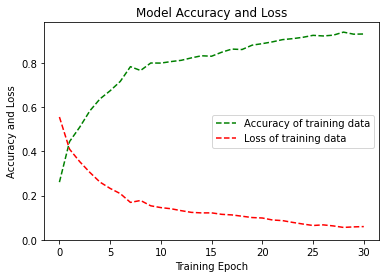

In [94]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [95]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS, no_of_features)
x_test.shape

(984, 60, 6)

In [96]:
score = model_lsnet.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

31/31 [==============================] - 1s 8ms/step - loss: 0.2459 - accuracy: 0.8161

Accuracy on test data: 0.82

Loss on test data: 0.25


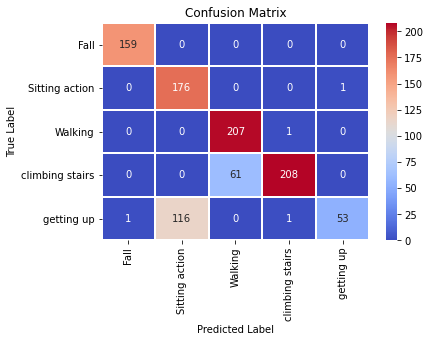


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       159
           1       0.60      0.99      0.75       177
           2       0.77      1.00      0.87       208
           3       0.99      0.77      0.87       269
           4       0.98      0.31      0.47       171

    accuracy                           0.82       984
   macro avg       0.87      0.81      0.79       984
weighted avg       0.87      0.82      0.80       984



In [97]:
y_pred_test = model_lsnet.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [98]:
model_lsnet.save('best_model_lsnet.h5')

### RNN Model

In [99]:
model_rnn = keras.Sequential()
model_rnn.add(Embedding(input_dim=TIME_PERIODS*no_of_features, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model_rnn.add(GRU(128, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dropout(0.4))
model_rnn.add(Dense(len(LABELS), activation='softmax'))

model_rnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          23040     
                                                                 
 gru (GRU)                   (None, None, 128)         74496     
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 5)                 325       
                                                                 
Total params: 110,213
Trainable params: 110,213
Non-trainable params: 0
_________________________________________________________________


In [100]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS*no_of_features)
x_train.shape

(2476, 360)

In [101]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

# opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_rnn.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
13/13 [==============================] - 10s 636ms/step - loss: 1.6220 - accuracy: 0.2161
Epoch 2/50
13/13 [==============================] - 8s 624ms/step - loss: 1.6044 - accuracy: 0.2407
Epoch 3/50
13/13 [==============================] - 8s 637ms/step - loss: 1.6161 - accuracy: 0.2508
Epoch 4/50
13/13 [==============================] - 10s 739ms/step - loss: 1.5962 - accuracy: 0.2682
Epoch 5/50
13/13 [==============================] - 10s 784ms/step - loss: 1.5713 - accuracy: 0.2896
Epoch 6/50
13/13 [==============================] - 10s 762ms/step - loss: 1.5989 - accuracy: 0.2815


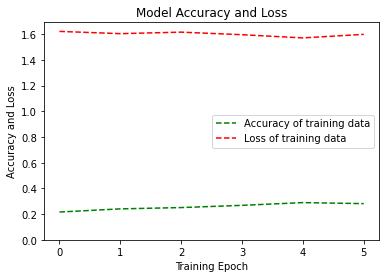

In [102]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [106]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS*no_of_features)
x_test.shape

(8723, 360)

In [107]:
score = model_rnn.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

273/273 [==============================] - 28s 99ms/step - loss: 1.2816 - accuracy: 0.5012

Accuracy on test data: 0.50

Loss on test data: 1.28


In [110]:
y_pred_test = model_rnn.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

# Making Predictions

In [104]:
data = pd.read_csv("data/combined_data.csv")
data = data[data['activity']!="Jogging"]

Test_data = data[data["user"].isin(['wamika'])]
Test_data = Test_data.append(zeon_data[zeon_data["activity"].isin(["climbing stairs"])])

activity = {'Fall': 0, 'Sitting action': 1, 'Walking': 2, 'climbing stairs': 3, 'getting up': 4}
le = preprocessing.LabelEncoder()
Test_data['encoded_label'] = le.fit_transform(Test_data['activity'].values.ravel())
print(le.classes_)

mu = [0.016859139784946162, -0.036989516129032354, 0.3306317204301088, -0.716561021505379, -0.41315268817204404, 0.056315860215054955]
sigma = [0.3169782064815828, 0.298379167917324, 0.5189035834200442, 55.572584842376756, 31.52775141330042, 32.75767648225105]


def normalize_features(data, mu_data, sigma_data):
    return (data - mu_data)/sigma_data

for i in range(0,6):
        Test_data.iloc[:, i] = normalize_features(Test_data.iloc[:, i], mu[i], sigma[i])
        
# Test_data = Test_data[100000:105000]
print(Test_data)

x_test_data, y_test_labels = create_segments(Test_data)
x_test_data = x_test_data.reshape(x_test_data.shape[0], TIME_PERIODS*no_of_features)
print("test data shape: ", x_test_data.shape)

model = keras.models.load_model('best_model_cnn.h5')

x_test_data = x_test_data.astype("float32")

pred = model.predict(x_test_data)
prediction = np.argmax(pred, axis=1)
print("Predictions:", prediction)
print("Actual:", y_test_labels)

['Fall' 'Sitting action' 'Walking' 'climbing stairs' 'getting up']
       accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z    user  \
16980    0.357    0.057    1.386  -0.070   0.229  -0.021  wamika   
16981    0.325    0.090    1.406   0.010   0.322  -0.081  wamika   
16982    0.294    0.124    1.406   0.017   0.314  -0.071  wamika   
16983    0.262    0.090    1.406  -0.020   0.318  -0.044  wamika   
16984    0.325    0.124    1.425  -0.006   0.374  -0.032  wamika   
...        ...      ...      ...     ...     ...     ...     ...   
53215   -0.053    0.124   -0.637   0.013  -0.177  -0.399    zeon   
53216   -0.053    0.124   -0.637  -0.221  -0.019  -0.093    zeon   
53217   -0.053    0.124   -0.637   0.265   0.299   0.334    zeon   
53218   -0.053    0.124   -0.637   0.139   0.077   0.639    zeon   
53219   -0.053    0.124   -0.637  -0.239  -0.177   0.456    zeon   

              activity  encoded_label  
16980             Fall              0  
16981             Fall              